**Загрузите датасет titanic из kaggle (https://www.kaggle.com/datasets/vinicius150987/titanic3) или с локального компьютера. (Data path на Kaggle = 'vinicius150987/titanic3', файл в формате Excel). Загрузите pandas dataframe, используя функцию pd.read_excel(). НЕполный датасет titanic есть также в seaborn.**

**Проверьте нуль-гипотезу о том, что средний возраст пассажиров (age) в группах с билетами разных классов (pclass) равен.
- Визуализируйте данные (звисимая переменная в трех группах).
- Постройте  таблицу ANOVA (используйте тип 2).
- Проверьте предположения.
- Проведите множественные сравнения, выбрав поправку.
- Интерпретируйте результаты статистически и содержательно.
- Не забудьте о кознях со стороны миссингов**

**Можно выбрать между библиотеками statsmodels и pingouin**

**Для тех, кому возраст пассажиров скучен: возьмите другой датафрейм из числа тех, что рассматривались в ноубуке s03a-Сравнение средних, напр., affairs, wcgs и др. Самостоятельно выберите интервальную зависимую переменную и фактор -- независимую переменную (рекомендуется с небольшим количеством уровней). Если клетки таблицы частот (pd.value_counts() ) для "фактора" окажутся пусты, придется объединить уровни (см основной ноутбук по этой теме или другие материалы). Все необходимые шаги остаются: визуализация, таблица ANOVA, предположения, множественные сравнения, интерпртетация, подстерегающие миссинги** 


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
# from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.multicomp as mc
import pingouin as pg
from scipy import stats


In [2]:
%pwd

'C:\\Users\\Professional\\extra_path'

In [6]:
import os
os.environ['vitalysramblerru'] = ''  # указываю свой username
os.environ['6020e9edf19ec97a66daad6377176481'] = ''       # указываю свой токен
import kaggle
kaggle.api.authenticate()

In [7]:
# Загрузка датасета Titanic
dataset_url = 'vinicius150987/titanic3'  # URL датасета
kaggle.api.dataset_download_files(dataset_url, path='.', unzip=True)  # Загрузка и распаковка

Dataset URL: https://www.kaggle.com/datasets/vinicius150987/titanic3


In [8]:
# Определяем имя файла (предполагаем, что это xls)
file_name = 'titanic3.xls'  # Убедитесь, что имя файла соответствует загруженному

# Загружаем данные в DataFrame
df = pd.read_excel(file_name)  # Используем read_excel для чтения файла

# Открываем первые пять строк
df.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [9]:
# Проверка на пропуски
missing_data = df.isnull().sum()
print(missing_data)

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


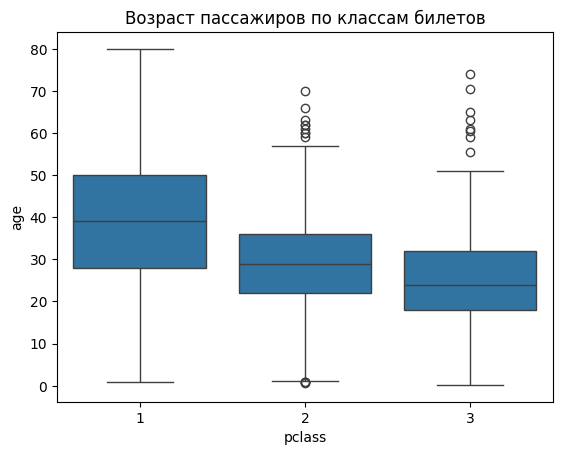

In [10]:
# Визуализация распределения возраста пассажиров по классам
sns.boxplot(x='pclass', y='age', data=df)
plt.title('Возраст пассажиров по классам билетов')
plt.show()

### Анализ дисперсии (ANOVA)
для проверки нуль-гипотезы о том, что средний возраст пассажиров в группах с билетами разных классов равен

In [12]:
from statsmodels.formula.api import ols

# Удаление строк с пропусками в age и pclass
df_clean = df.dropna(subset=['age', 'pclass'])

# Построение модели
model = ols('age ~ C(pclass)', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq      df           F        PR(>F)
C(pclass)   37339.390553     2.0  108.325978  1.797203e-43
Residual   179758.286859  1043.0         NaN           NaN


####
Значимость различий:

F-статистика: Значение F (108.33) указывает на то, что вариация между группами (в данном случае, классами пассажиров) значительно превышает вариацию внутри групп. Это говорит о том, что классы пассажиров имеют разные средние значения по рассматриваемой переменной.

p-value: Значение p-value (1.7972e-43) крайне мало и значительно меньше стандартного уровня значимости (0.05). Это означает, что мы отвергаем нулевую гипотезу, которая утверждает, что средние значения всех классов пассажиров равны.

Выводы:
На основании результатов ANOVA можно заключить, что существуют значимые различия между средними значениями по классам пассажиров на Титанике. Это может указывать на то, что класс пассажира (например, 1-й, 2-й или 3-й) влияет на рассматриваемую переменную (например, выживаемость).

#### Для проверки предположений ANOVA (нормальность и гомогенность дисперсий) можно использовать тесты Шапиро-Уилка и Левена:

In [13]:
from scipy import stats

# Тест Шапиро-Уилка для нормальности
shapiro_test = stats.shapiro(df_clean['age'])
print('Тест Шапиро-Уилка:', shapiro_test)

# Тест Левена для гомогенности дисперсий
levene_test = stats.levene(df_clean[df_clean['pclass'] == 1]['age'],
                            df_clean[df_clean['pclass'] == 2]['age'],
                            df_clean[df_clean['pclass'] == 3]['age'])
print('Тест Левена:', levene_test)

Тест Шапиро-Уилка: ShapiroResult(statistic=np.float64(0.9795478899942606), pvalue=np.float64(5.749827483537655e-11))
Тест Левена: LeveneResult(statistic=np.float64(12.572361659703366), pvalue=np.float64(4.024111527944504e-06))


#### 
Тест Шапиро-Уилка используется для проверки гипотезы о нормальности распределения данных. Нулевая гипотеза (H0) утверждает, что данные распределены нормально. В данном случае, полученное значение статистики (0.9795) близко к 1, что обычно указывает на нормальность, но p-value (5.7498e-11) значительно меньше стандартного уровня значимости (например, 0.05). Это означает, что мы отвергаем нулевую гипотезу и можем заключить, что данные не распределены нормально.

Тест Левена используется для проверки равенства дисперсий между двумя или более группами. Нулевая гипотеза (H0) утверждает, что дисперсии равны. В данном случае, значение статистики (12.5724) указывает на значительное различие между дисперсиями, а p-value (4.0241e-06) также значительно меньше 0.05. Это позволяет отвергнуть нулевую гипотезу, что говорит о том, что дисперсии между группами различаются.

In [14]:
# Поскольку ANOVA показывает значимые различия, проведем множественные сравнения с поправкой Тьюки:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Множественные сравнения
tukey = pairwise_tukeyhsd(endog=df_clean['age'], groups=df_clean['pclass'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     1      2  -9.6532   0.0 -12.2953  -7.0111   True
     1      3 -14.3436   0.0 -16.6322 -12.0549   True
     2      3  -4.6903   0.0  -7.0425  -2.3382   True
-----------------------------------------------------


#### Результаты теста Тьюки HSD (Honestly Significant Difference) показывают, что мы сравниваем средние значения возраста пассажиров в разных классах билетов (pclass). 

Основные выводы:

Сравнение классов 1 и 2:
meandiff: Средний возраст пассажиров в классе 1 на 9.65 лет старше, чем в классе 2.
p-adj: Значение p меньше 0.05, что указывает на статистически значимую разницу между этими группами.
reject: Мы отвергаем нуль-гипотезу, что средние значения возраста в этих группах равны.

Сравнение классов 1 и 3:
meandiff: Средний возраст пассажиров в классе 1 на 14.34 года старше, чем в классе 3.
p-adj: Значение p также меньше 0.05, что подтверждает статистическую значимость.
reject: Мы отвергаем нуль-гипотезу для этого сравнения.

Сравнение классов 2 и 3:
meandiff: Средний возраст пассажиров в классе 2 на 4.69 года больше, чем в классе 3.
p-adj: Значение p меньше 0.05, что указывает на статистически значимую разницу.
reject: Мы также отвергаем нуль-гипотезу для этого сравнения.


Общая интерпретация:

Все три сравнения показывают, что существует статистически значимая разница в среднем возрасте пассажиров между классами билетов. Пассажиры первого класса, как правило, старше, чем пассажиры второго и третьего классов. Это может указывать на то, что более состоятельные пассажиры (первый класс) имеют тенденцию быть старше, чем пассажиры, выбирающие более дешевые классы.


Заключение:

Результаты теста Тьюки HSD подтверждают, что возраст пассажиров Титаника различается в зависимости от класса билета. Это может быть важным аспектом для дальнейшего анализа, например, в контексте социально-экономических факторов, влияющих на выбор класса билета.